In [1]:
%gui qt

In [1]:
import napari
import sys
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.trench_geometry import trench_creator
from SYMPTOMM.phase_contrast_drawing import *
import tifffile
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
div_odd = lambda n: (n//2, n//2 + 1)
perc_diff = lambda a, b: abs(a-b)/((a+b)/2)
from skimage.exposure import rescale_intensity
from ipywidgets import interactive
import os
from PIL import Image
import skimage
from tqdm.notebook import tqdm
import gc

real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/trench_{}/T_{}.tif".format(
    str(np.random.randint(1,56)).zfill(2),
    str(np.random.randint(0,5)).zfill(3)))

#viewer = napari.view_image(real_image)


In [3]:
real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/Lane_02_pos_002_trench_x_1963_y_0067_w_0046_h_0460_c_Phase.tif")[0][:300,:]


## FuncDefs

In [23]:
def run_simulation(trench_length, trench_width, cell_max_length, cell_width, sim_length):
    
    
    space = create_space()
    space.gravity = 0, 0 # arbitrasry units
    dt = 1/100 #time-step per frame
    pix_mic_conv = 10 # pixels per micron
    scale_factor = pix_mic_conv * 3 # resolution scaling factor 

    trench_length = trench_length*scale_factor
    trench_width = trench_width*scale_factor
    trench_creator(trench_width,trench_length,(35,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*3,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*5,0),space) # Coordinates of bottom left corner of the trench

    cell1 = Cell(
        length = cell_max_length*scale_factor,  
        width = cell_width*scale_factor, 
        resolution = 60, 
        position = (20+35,40), 
        angle = 0.8, 
        space = space,
        dt = 1/60,
        growth_rate_constant = 1,
        max_length = cell_max_length*scale_factor,
        max_length_mean =cell_max_length*scale_factor,
        max_length_var = 0.5*np.sqrt(scale_factor),
        width_var = 0.07*np.sqrt(scale_factor),
        width_mean = cell_width*scale_factor
    )


    cells = [cell1]
    cell_timeseries = []
    phys_iters = 250
    for x in tqdm(range(sim_length+250),desc="Simulation Progress"):
        cells = step_and_update(dt=dt, cells=cells, space=space, phys_iters=phys_iters,ylim=trench_length)
        if x > 250:
            cell_timeseries.append(deepcopy(cells))
    return cell_timeseries, space


def get_similarity_metrics(real_image,synthetic_image):
    synthetic_image = match_histograms(synthetic_image, real_image, multichannel=False)
    synthetic_image = resize(synthetic_image,real_image.shape,clip=False,preserve_range=False,anti_aliasing=None)
    synthetic_image = synthetic_image/np.max(synthetic_image)
    ssim_real = ssim(synthetic_image, real_image)
    intersection = return_intersection_between_image_hists(synthetic_image, real_image, 100)
    #sims 
    synthetic_image_ = deepcopy(synthetic_image)
    synthetic_image_.shape += (1,)
    
    real_image_ = deepcopy(real_image)
    real_image_.shape += (1,)
    _fsim = fsim(synthetic_image_,real_image_)
    _issm = issm(synthetic_image_,real_image_)
    _sam = sam(synthetic_image_,real_image_)
    _sre = sre(synthetic_image_,real_image_)
    objs = [ssim_real, 0.5*intersection, _fsim, _issm, _sam, _sre/20]
    return objs

def generate_PC_OPL(main_segments, offset, scene, mask, media_multiplier,cell_multiplier,device_multiplier):
    def get_OPL_image():
        segment_1_top_left = (0 + offset, int(main_segments.iloc[0]["bb"][0] + offset))
        segment_1_bottom_right = (int(main_segments.iloc[0]["bb"][3] + offset), int(main_segments.iloc[0]["bb"][2] + offset))

        segment_2_top_left = (0 + offset, int(main_segments.iloc[1]["bb"][0] + offset))
        segment_2_bottom_right = (int(main_segments.iloc[1]["bb"][3] + offset), int(main_segments.iloc[1]["bb"][2] + offset))

        test_scene = np.zeros(scene.shape) + device_multiplier
        rr, cc = draw.rectangle(start = segment_1_top_left, end = segment_1_bottom_right, shape = test_scene.shape)
        test_scene[rr,cc] = 1 * media_multiplier
        rr, cc = draw.rectangle(start = segment_2_top_left, end = segment_2_bottom_right, shape = test_scene.shape)
        test_scene[rr,cc] = 1 * media_multiplier
        circ_midpoint_y = (segment_1_top_left[1] + segment_2_bottom_right[1])/2
        radius = (segment_1_top_left[1] - offset - (segment_2_bottom_right[1] - offset))/2
        circ_midpoint_x = (offset) + radius

        rr, cc = draw.rectangle(start = segment_2_top_left, end = (circ_midpoint_x,segment_1_top_left[1]), shape = test_scene.shape)
        test_scene[rr.astype(int),cc.astype(int)] = 1 * media_multiplier
        rr, cc = draw.disk(center = (circ_midpoint_x, circ_midpoint_y), radius = radius, shape = test_scene.shape)
        rr_semi = rr[rr < (circ_midpoint_x + 1)]
        cc_semi = cc[rr < (circ_midpoint_x + 1)]
        test_scene[rr_semi,cc_semi] = device_multiplier
        no_cells = deepcopy(test_scene)
        test_scene += scene * cell_multiplier
        test_scene = test_scene[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        mask_resized = mask[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        
        no_cells = no_cells[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        expanded_scene_no_cells = np.zeros((int(no_cells.shape[0]*1.2), no_cells.shape[1]*2)) + media_multiplier
        expanded_scene_no_cells[expanded_scene_no_cells.shape[0] - no_cells.shape[0]:,int(no_cells.shape[1]/2):int(no_cells.shape[1]/2) + no_cells.shape[1]] = no_cells

        expanded_scene = np.zeros((int(test_scene.shape[0]*1.2), test_scene.shape[1]*2)) + media_multiplier
        expanded_scene[expanded_scene.shape[0] - test_scene.shape[0]:,int(test_scene.shape[1]/2):int(test_scene.shape[1]/2) + test_scene.shape[1]] = test_scene
        
        expanded_mask = np.zeros((int(test_scene.shape[0]*1.2), test_scene.shape[1]*2))
        expanded_mask[expanded_mask.shape[0] - test_scene.shape[0]:,int(test_scene.shape[1]/2):int(test_scene.shape[1]/2) + test_scene.shape[1]] = mask_resized
        
        return expanded_scene, expanded_scene_no_cells, expanded_mask
    expanded_scene, expanded_scene_no_cells, expanded_mask = get_OPL_image()
    if expanded_scene is None:
        main_segments = main_segments.reindex(index=main_segments.index[::-1])
        expanded_scene, expanded_scene_no_cells, expanded_mask = get_OPL_image()
    return expanded_scene, expanded_scene_no_cells, expanded_mask

def convolve_rescale(image,kernel,rescale_factor, rescale_int):
    output = cuconvolve(cp.array(image),cp.array(kernel))
    output = output.get()
    output = rescale(output, rescale_factor, anti_aliasing=False)
    
    if rescale_int:
        output = rescale_intensity(output.astype(np.float32), out_range=(0,1))
    return output

#make convolved image and real image same shape
def make_images_same_shape(real_image,synthetic_image, rescale_int = True):
    x_diff = synthetic_image.shape[1] - real_image.shape[1]
    remove_from_left, remove_from_right = div_odd(x_diff)
    y_diff = synthetic_image.shape[0] - real_image.shape[0]
    if y_diff > 0:
        synthetic_image = synthetic_image[y_diff:,remove_from_left-1:-remove_from_right]
    else:
        synthetic_image = synthetic_image[:,remove_from_left:-remove_from_right]
        real_image = real_image[abs(y_diff):,:]

    if rescale_int:
        real_image = rescale_intensity(real_image.astype(np.float32), out_range=(0,1))
        synthetic_image = rescale_intensity(synthetic_image.astype(np.float32), out_range=(0,1))
    return real_image, synthetic_image

def generate_test_comparison(media_multiplier, cell_multiplier, device_multiplier, sigma, scene_no, scale, match_histogram, match_noise, offset, debug_plot=True, noise_var=0.002):
    
    
    expanded_scene, expanded_scene_no_cells, expanded_mask = generate_PC_OPL(
        main_segments=main_segments,
        offset=offset,
        scene = scenes[scene_no][0],
        mask = scenes[scene_no][1],
        media_multiplier=media_multiplier,
        cell_multiplier=cell_multiplier,
        device_multiplier=device_multiplier
    )




    kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, sigma, 0.75)



    convolved = convolve_rescale(expanded_scene, kernel, 1/resize_amount, rescale_int = True)
    real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)
    
    
    if match_histogram:
        matched = match_histograms(expanded_resized, real_resize, multichannel=False)
    else:
        matched = expanded_resized
    
    
    noisy_img = random_noise(rescale_intensity(matched), mode="poisson")
    noisy_img = random_noise(rescale_intensity(noisy_img), mode="gaussian", mean=0,var=noise_var,clip=False)
    
    if match_noise:
        noisy_img = match_histograms(noisy_img, real_resize, multichannel=False)
    else:
        pass
    noisy_img = rescale_intensity(noisy_img.astype(np.float32), out_range=(0,1))
    
    ## getting the cell mask to the right shape
    expanded_mask_resized = rescale(expanded_mask, 1/resize_amount, anti_aliasing=False)
    _, expanded_mask_resized_reshaped = make_images_same_shape(real_image,expanded_mask_resized, rescale_int=True)


    

    
    expanded_media_mask = rescale((expanded_scene_no_cells == device_multiplier) ^ (expanded_scene - expanded_scene_no_cells).astype(bool) , 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_media_mask = make_images_same_shape(real_image,expanded_media_mask, rescale_int=True)
    just_media = expanded_media_mask * noisy_img
    
    expanded_cell_pseudo_mask = (expanded_scene - expanded_scene_no_cells).astype(bool)
    expanded_cell_pseudo_mask = rescale(expanded_cell_pseudo_mask, 1/resize_amount, anti_aliasing=False)

    real_resize, expanded_cell_pseudo_mask = make_images_same_shape(real_image,expanded_cell_pseudo_mask, rescale_int=True)
    just_cells = expanded_cell_pseudo_mask * noisy_img
    
    expanded_device_mask = expanded_scene_no_cells == media_multiplier
    expanded_device_mask = rescale(expanded_device_mask, 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_device_mask = make_images_same_shape(real_image,expanded_device_mask, rescale_int=True)
    just_device = expanded_device_mask * noisy_img
    
    
    
    
    simulated_means = np.array([just_media[np.where(just_media)].mean(), just_cells[np.where(just_cells)].mean(), just_device[np.where(just_device)].mean()])
    simulated_vars = np.array([just_media[np.where(just_media)].var(), just_cells[np.where(just_cells)].var(), just_device[np.where(just_device)].var()])

    
    
    mean_error.append(np.mean(perc_diff(real_means, simulated_means)))
    media_error.append(perc_diff(simulated_means[0], real_media_mean))
    cell_error.append(perc_diff(simulated_means[1], real_cell_mean))
    device_error.append(perc_diff(simulated_means[2], real_device_mean))
    
    
    mean_var_error.append(np.mean(perc_diff(real_vars, simulated_vars)))
    media_var_error.append(perc_diff(simulated_vars[0], real_media_var))
    cell_var_error.append(perc_diff(simulated_vars[1], real_cell_var))
    device_var_error.append(perc_diff(simulated_vars[2], real_device_var))
    if debug_plot == True:
        fig = plt.figure(figsize=(15,5))
        ax1 = plt.subplot2grid((1,8),(0,0),colspan=1,rowspan=1)
        ax2 = plt.subplot2grid((1,8),(0,1),colspan=1,rowspan=1)
        ax3 = plt.subplot2grid((1,8),(0,2),colspan=3,rowspan=1)
        ax4 = plt.subplot2grid((1,8),(0,5),colspan=3,rowspan=1)
        ax1.imshow(noisy_img,cmap="Greys_r")
        ax1.set_title("Synthetic")
        ax1.axis("off")
        ax2.imshow(real_resize,cmap="Greys_r")
        ax2.set_title("Real")
        ax2.axis("off")
        ax3.plot(mean_error)
        ax3.plot(media_error)
        ax3.plot(cell_error)
        ax3.plot(device_error)
        ax3.legend(["Mean error", "Media error", "Cell error", "Device error"])
        ax3.set_title("Intensity Error")

        ax4.plot(mean_var_error)
        ax4.plot(media_var_error)
        ax4.plot(cell_var_error)
        ax4.plot(device_var_error)
        ax4.legend(["Mean error", "Media error", "Cell error", "Device error"])
        ax4.set_title("Variance Error")

        fig.tight_layout()
        plt.show()
        plt.close()
    else:
        return noisy_img, expanded_mask_resized_reshaped

def get_space_size(cell_timeseries_properties):
    """Iterates through the simulation timeseries properties, 
    finds the extreme cell positions and retrieves the required 
    image size to fit all cells into"""
    max_x, max_y = 0, 0
    for timepoint in cell_timeseries_properties:
        for cell in timepoint:
            x_, y_ = np.ceil(cell[3]).astype(int)
            length_ = np.ceil(cell[0]).astype(int)
            width_ = np.ceil(cell[1]).astype(int)
            max_y_ = y_ + length_
            max_x_ = x_ + width_
            if max_x_ > max_x:
                max_x = max_x_
            if max_y_ > max_y:
                max_y = max_y_
    return (int(1.2*max_y), int(1.5*max_x))

### Do large cells

In [112]:
sim_length = 750
cell_timeseries, space = run_simulation(trench_length=15, trench_width=1.45, cell_max_length=5.5, cell_width=1.05, sim_length = sim_length) # growth phase
#cell_timeseries, space = run_simulation(trench_length=15.5, trench_width=1.25, cell_max_length=1.45, cell_width=0.85, sim_length = sim_length) # stationary phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=14)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties:'))
do_transformation = False
offset = 5
mask_threshold = 17
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Simulation Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Timeseries Properties::   0%|          | 0/749 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/749 [00:00<?, ?it/s]

In [26]:
media_multiplier=-30
cell_multiplier=-1
device_multiplier=150


condensers = get_condensers()
W, R, diameter = condensers["Ph2"]
scale = 0.108379937 / 3 #0.35 #micron per pixel
min_sigma = 0.42*0.6/6 / scale # micron

resize_amount = 1/scale/10



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
    main_segments=main_segments,
    offset=50,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=1,
    cell_multiplier=1,
    device_multiplier=1
)

temp_kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, min_sigma, 0.75)



convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

viewer = napari.view_image(real_resize)
media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

In [87]:
real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

In [113]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []


params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.1),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_histogram = [True, False],
    match_noise = [True, False],
offset=(offset,offset,offset));

In [114]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [115]:
gc.collect()

353343

In [116]:
def generate_training_data(interactive_output, sample_amount, randomise_hist_match, randomise_noise_match, sim_length, burn_in, n_samples, save_dir):
    media_multiplier, cell_multiplier, device_multiplier, sigma, scene_no, scale, match_histogram, match_noise, offset, debug_plot, noise_var = list(interactive_output.kwargs.values())
    debug_plot = False
    
    try:
        os.mkdir(save_dir + "/convolutions")
    except:
        pass
    try:
        os.mkdir(save_dir + "/masks")
    except:
        pass
        
    current_file_num = len(os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/convolutions"))
    #for z in range(n_samples):
    def generate_samples(z):
        _media_multiplier = np.random.uniform(1-sample_amount,1+sample_amount) * media_multiplier
        _cell_multiplier = np.random.uniform(1-sample_amount,1+sample_amount) * cell_multiplier
        _device_multiplier = np.random.uniform(1-sample_amount,1+sample_amount) * device_multiplier
        _sigma = np.random.uniform(1-sample_amount,1+sample_amount) * sigma
        _scene_no = np.random.randint(burn_in,sim_length-2)
        _noise_var = np.random.uniform(1-sample_amount,1+sample_amount) * noise_var
        if randomise_hist_match:
            _match_histogram = np.random.choice([True, False])
        if randomise_noise_match:
            _match_noise = np.random.choice([True, False])
        
        syn_image, mask = generate_test_comparison(_media_multiplier, _cell_multiplier, _device_multiplier, _sigma, _scene_no, scale, _match_histogram, match_noise, offset, debug_plot, noise_var)
        
        syn_image = Image.fromarray(skimage.img_as_uint(rescale_intensity(syn_image)))
        syn_image.save("{}/convolutions/synth_{}.tif".format(save_dir, str(z).zfill(5)))
        mask = Image.fromarray(mask)
        mask.save("{}/masks/synth_{}.tif".format(save_dir, str(z).zfill(5)))        
    ## TODO: change parallel if not using GPU
    Parallel(n_jobs=1)(delayed(generate_samples)(z) for z in tqdm(range(current_file_num,n_samples+current_file_num), desc="Sample generation:"))

In [118]:
generate_training_data(interactive_output = params, sample_amount = 0.02, randomise_hist_match = True, randomise_noise_match = True, sim_length = sim_length, burn_in = 0, n_samples =  1500, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/")

Sample generation::   0%|          | 0/1500 [00:00<?, ?it/s]

### Do small cells

In [73]:
def draw_scene(cell_properties, do_transformation, mask_threshold, space_size, offset):
    space_size = np.array(space_size) # 1000, 200 a good value
    space = np.zeros(space_size)
    space_masks = np.zeros(space_size)
    offsets = offset 
    for properties in cell_properties:
        length, width, angle, position, freq_modif, amp_modif, phase_modif,phase_mult = properties
        length = length; width = width ; position = np.array(position) 
        angle = np.rad2deg(angle) - 90
        x, y = np.array(position).astype(int) + offsets
        OPL_cell = raster_cell(length = length, width=width)
        
        if do_transformation:
            OPL_cell_2 = np.zeros((OPL_cell.shape[0],int(OPL_cell.shape[1]*2)))
            midpoint = int(np.median(range(OPL_cell_2.shape[1])))
            OPL_cell_2[:,midpoint-int(OPL_cell.shape[1]/2):midpoint-int(OPL_cell.shape[1]/2)+OPL_cell.shape[1]] = OPL_cell
            roll_coords = np.array(range(OPL_cell_2.shape[0]))
            freq_mult = (OPL_cell_2.shape[0])
            amp_mult = OPL_cell_2.shape[1]/10
            sin_transform_cell = transform_func(amp_modif, freq_modif, phase_modif)
            roll_amounts = sin_transform_cell(roll_coords,amp_mult,freq_mult,phase_mult)
            for B in roll_coords:
                OPL_cell_2[B,:] = np.roll(OPL_cell_2[B,:], roll_amounts[B])
            OPL_cell = (OPL_cell_2)
        
        rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
        cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
        offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
        offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
        assert y > cell_y, "Cell has {} negative pixels in y coordinate, try increasing your offset".format(y - cell_y)
        assert x > cell_x, "Cell has negative pixels in x coordinate, try increasing your offset"
        space[
            y-cell_y:y+cell_y+offset_y,
            x-cell_x:x+cell_x+offset_x
        ] += rotated_OPL_cell
        space_masks[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] += (rotated_OPL_cell > mask_threshold)
        space_masks = space_masks == 1


        #space_masks = opening(space_masks,np.ones((2,11)))
    return space, space_masks

In [ ]:
sim_length = 200
cell_timeseries, space = run_simulation(trench_length=15.5, trench_width=1.25, cell_max_length=1.45, cell_width=0.85, sim_length = sim_length) # stationary phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties:'))
do_transformation = False
offset = 20
mask_threshold = 17
space_size = (1000,200)
scenes = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Simulation Progress:   0%|          | 0/450 [00:00<?, ?it/s]

Timeseries Properties::   0%|          | 0/199 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/199 [00:00<?, ?it/s]

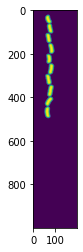

In [82]:
plt.imshow(scenes[-1][0])

In [78]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []


params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.1),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=scale,
    match_histogram = [True, False],
    match_noise = [True, False],
offset=(offset,offset,offset));
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [85]:
generate_training_data(interactive_output = params, sample_amount = 0.095, randomise_hist_match = True, randomise_noise_match = True, sim_length = sim_length, burn_in = 0, n_samples =  120, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/")

Sample generation::   0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
def get_images_to_optimise(expanded_scene,expanded_scene_no_cells,expanded_resized, real_image, convolved, resize_amount):
    expanded_media_mask = rescale((expanded_scene_no_cells == device_multiplier) ^ (expanded_scene - expanded_scene_no_cells).astype(bool) , 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_media_mask = make_images_same_shape(real_image,expanded_media_mask, rescale_int=True)
    just_media = expanded_media_mask * expanded_resized
    
    expanded_cell_pseudo_mask = (expanded_scene - expanded_scene_no_cells).astype(bool)
    expanded_cell_pseudo_mask = rescale(expanded_cell_pseudo_mask, 1/resize_amount, anti_aliasing=False)

    real_resize, expanded_cell_pseudo_mask = make_images_same_shape(real_image,expanded_cell_pseudo_mask, rescale_int=True)
    just_cells = expanded_cell_pseudo_mask * expanded_resized
    
    expanded_device_mask = expanded_scene_no_cells == media_multiplier
    expanded_device_mask = rescale(expanded_device_mask, 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_device_mask = make_images_same_shape(real_image,expanded_device_mask, rescale_int=True)
    just_device = expanded_device_mask * expanded_resized
    
    return just_media, just_cells, just_device, expanded_media_mask, expanded_cell_pseudo_mask, expanded_device_mask

just_media, just_cells, just_device, perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask = get_images_to_optimise(expanded_scene,expanded_scene_no_cells,expanded_resized, real_image, convolved, resize_amount)

In [ ]:
def get_intensity_means(perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask, expanded_resized):
    return (perm_expanded_media_mask * expanded_resized).mean(), (perm_expanded_cell_pseudo_mask * expanded_resized).mean(), (perm_expanded_device_mask * expanded_resized).mean()

In [ ]:
OPL_image_convolved = []
global current_error
current_error = 10
best_input = []

def objective_function(v, return_diagnostics = False):
    global current_error
    media_multiplier, cell_multiplier, device_multiplier= v
    expanded_scene, expanded_scene_no_cells, expanded_mask = generate_PC_OPL(
    main_segments=main_segments,
    offset=50,
    scene = scenes[4][0],
    mask = scenes[4][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=device_multiplier
    )


    resize_amount = 1/scale/10

    ## Creating the synthetic image
    kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, 7, 0.6)
    convolved = convolve_rescale(expanded_scene, kernel, resize_amount, rescale_int = True)
    real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

    ## getting the cell mask to the right shape
    expanded_mask_resized = rescale(expanded_mask,1/resize_amount, anti_aliasing=False)
    real_resize, expanded_mask_resized_reshaped = make_images_same_shape(real_image,expanded_mask_resized, rescale_int=True)
    _, _, _, perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask = get_images_to_optimise(expanded_scene,expanded_scene_no_cells,expanded_resized, real_image, convolved, resize_amount)
    simulated_means = np.array(get_intensity_means(perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask, expanded_resized))

    perc_sum = sum(perc_diff(real_means, simulated_means))

    if perc_sum < current_error:
        current_error = perc_sum
        print(current_error)
        best_input.append(v)
        OPL_image_convolved.append(expanded_resized)
    
    if return_diagnostics == True:
        return expanded_resized, simulated_means, perc_sum
    else:
        if np.isnan(perc_sum):
            return 100
        else:
            return perc_sum

In [ ]:
objective_function(np.array([-20,-1,20]), return_diagnostics = True)[1]

In [ ]:
plt.imshow(objective_function(np.array([-20,-1,10]), return_diagnostics = True)[0], cmap="Greys_r", vmax=1.5)

In [ ]:
(perm_expanded_cell_pseudo_mask*objective_function(np.array([-20,-1,20]), return_diagnostics = True)[0]).mean()

In [ ]:
get_intensity_means(perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask, objective_function(np.array([-20,-1,20]), return_diagnostics = True)[0])

In [ ]:
perc_diff = lambda a, b: abs(a-b)/abs((a+b)/2)


In [ ]:
progress = []
def callbackF(x, f, context):
    print(x)
    progress.append(x)
    
def callbackSHGo(x):
    print(x)
    progress.append(x)

In [ ]:
bounds = list(zip([-500, -500, -500], [500.0, 500.0, 500.0]))

In [ ]:
#ret = shgo(objective_function, bounds = np.array(bounds),callback=callbackSHGo,options={"minimize_every_iter":True})
ret = dual_annealing(objective_function, bounds = np.array(bounds),callback=callbackF) # ,maxiter=10,initial_temp=5*10**4

In [ ]:
ret = basinhopping(objective_function, x0 = (0,0,0),callback=callbackF) 

In [ ]:
from scipy.optimize import differential_evolution

In [ ]:
ret = differential_evolution(objective_function, bounds, popsize = 200, mutation = 1.999)

In [ ]:
ranges = [np.arange(-50,50, 5), np.arange(-50,50, 5), np.arange(-50,50, 5)]

In [ ]:
inputs = (list(itertools.product(*ranges)))

In [ ]:
import random

In [ ]:
np.random.uniform(low=-1000,high=1000,size=(3))

In [ ]:
OPL_image_convolved = []
current_error = 10
best_input = []
a = 0
while True:    
    temp_output = objective_function(np.random.uniform(low=-1000,high=1000,size=(3)), True)
    a+=1
    if temp_output[1] < current_error:
        current_error = temp_output[1]
        print(current_error)
        best_input.append(list(input_) + [3.9])
        OPL_image_convolved.append(temp_output[0])


In [ ]:
plt.imshow(OPL_image_convolved[-1])